# Bayes 3D Image Likelihood constrained to rays

TODO:

- [ ] Test for correctness
- [ ] Do performance evaluation and compare with 3dp3 Likelihood. Probably B3D is 2x slower.

In [1]:
#|default_exp likelihood

In [2]:
#|export
import jax
from jax import (jit, vmap)
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import genjax
from genjax import gen


console = genjax.pretty(show_locals=False)

In [3]:
#|export
from scipy.stats import truncnorm as scipy_truncnormal

normal_logpdf = jax.scipy.stats.norm.logpdf
truncnorm_pdf = jax.scipy.stats.truncnorm.pdf
truncnorm_logpdf = jax.scipy.stats.truncnorm.logpdf
logsumexp = jax.scipy.special.logsumexp


In [4]:
# 
# Monkey patching `sample` for `BuiltinGenerativeFunction`
# 
cls = genjax._src.generative_functions.builtin.builtin_gen_fn.BuiltinGenerativeFunction

def genjax_sample(self, key, *args, **kwargs):
    _, tr = self.simulate(key, args)
    return tr.get_retval()

setattr(cls, "sample", genjax_sample)


# 
# Monkey patching `sample` for `DeferredGenerativeFunctionCall`
# 
cls = genjax._src.generative_functions.builtin.builtin_gen_fn.DeferredGenerativeFunctionCall

def deff_gen_func_call(self, key, **kwargs):
    return self.gen_fn.sample(key, *self.args, **kwargs)

def deff_gen_func_logpdf(self, x, **kwargs):
    return self.gen_fn.logpdf(x, *self.args, **kwargs)

setattr(cls, "__call__", deff_gen_func_call)
setattr(cls, "logpdf", deff_gen_func_logpdf)

In [5]:
def keysplit(key, *ns):
    if len(ns) == 0:

        return jax.random.split(key, 1)[0]
    
    else:

        keys = []
        for n in ns:
            if n == 1: keys.append(jax.random.split(key, 1)[0])
            else: keys.append(jax.random.split(key, n))

        return keys


In [6]:
key = jax.random.PRNGKey(0)

Let's take a look at how truncated normals are used.

[<matplotlib.lines.Line2D object at 0x7fb0a4d594f0>]

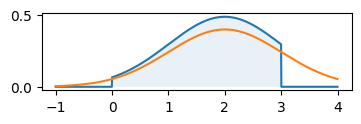

In [7]:
sig = 1.0
mu  = 2.0

low  = 0.0
high = 3.0

xs = jnp.linspace(-1.,4, 1_000)
ys = truncnorm_logpdf(xs, (low - mu)/sig, (high - mu)/sig, loc=mu, scale=sig)
zs = normal_logpdf(xs, mu, sig)

# ---------------------
fig, axs = plt.subplots(1,1,figsize=(4,1))
axs.fill_between(xs, jnp.exp(ys), 0.0, alpha=0.1)
axs.plot(xs, jnp.exp(ys))
axs.plot(xs, jnp.exp(zs))

(100, 200, 3)


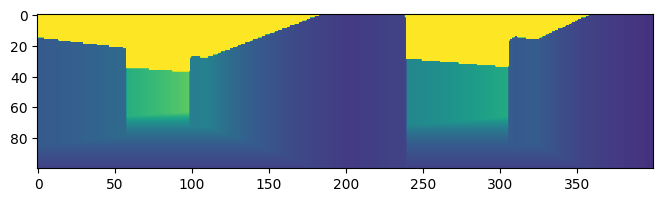

In [8]:
imgs = []
for t in range(10):
    im = np.load(f"./data/test_imgs/img_{t}.npy")
    imgs.append(jnp.array(im))

imgs = jnp.array(imgs)


X = imgs[7,:,:,:3]
Y = imgs[9,:,:,:3]
print(X.shape)
# ---------------------
plt.figure(figsize=(8,2))
plt.imshow(jnp.concatenate([X[:,:,2],Y[:,:,2]], axis=1), vmin=0., vmax=5);

In [9]:
#|export
def get_1d_mixture_components(x, ys, sig):

    # 1D-Mixture components and value to evaluate.
    # These are given by the distances ALONG ray through `x`
    d  = jnp.linalg.norm(x)
    ds = ys @ x / d
    
    # 1D-Mixture weights.
    # First compute the distances TO ray through `x`
    # and then transforming them appropriately.
    ws = jnp.linalg.norm(ds[...,None] * x/d - ys, axis=-1)
    ws = normal_logpdf(ws, loc=0.0, scale=sig)
    
    # Check for padded values and (log-)zero out
    # ws = jnp.where(ys[...,2] == -100., -jnp.inf, ws)
    ws = ws - logsumexp(ws)

    return d, ds, ws

In [10]:
#|export
# Some helper to keep code concise
def dslice(X, i,j, w): 
    return  jax.lax.dynamic_slice(X, (i, j, 0), (2*w + 1, 2*w + 1, 3))   

def adjusted_dslice(X, i,j, w): 
    i_ = jnp.maximum(i-w, 0)
    j_ = jnp.maximum(j-w, 0)
    return  jax.lax.dynamic_slice(X, (i_, j_, 0), (2*w + 1, 2*w + 1, 3))    

def pad(X, w, val=-100.):
    return jax.lax.pad(X,  val, ((w,w,0),(w,w,0),(0,0,0)))

pad_jit = jit(pad, static_argnames=("w",))

def mix_std(ps, mus, stds):
    """Standard Deviation of a mixture of Gaussians."""
    return jnp.sqrt(jnp.sum(ps*stds**2) + jnp.sum(ps*mus**2) - (jnp.sum(ps*mus))**2)

## Baseline

In [11]:
# class Reshape():
    # def __init__(self, shape,)

In [12]:
#|export
import genjax._src.generative_functions.distributions.tensorflow_probability as gentfp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions


gaussian_mixture = gentfp.TFPDistribution(
    lambda logps, mus, sig: tfd.MixtureSameFamily(
        tfd.Categorical(logps),
        tfd.MultivariateNormalDiag(mus, sig * jnp.ones_like(mus)))
)

In [13]:
w   = 10
sig = 1.0
ys  = jnp.array(np.random.randn(2*w+1,3))

key = keysplit(key)
%timeit -n 1 -r 1 gaussian_mixture.sample(key, jnp.zeros(2*w+1), ys, sig);
x = gaussian_mixture.sample(key, jnp.zeros(2*w+1), ys, sig)
x

2.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Array([0.7948035 , 1.1532966 , 0.10081136], dtype=float32)

In [14]:
jnp.mgrid[:2,:4][0]
jnp.meshgrid(jnp.arange(2),jnp.arange(4), indexing="ij")[0]

Array([[0, 0, 0, 0],
       [1, 1, 1, 1]], dtype=int32)

In [15]:
def adjusted_dslice_2(X, i,j, w): 
    i_ = jnp.maximum(i-w, 0)
    j_ = jnp.maximum(j-w, 0)
    return  jax.lax.dynamic_slice(X, (i_, j_, 0), (2*w + 1, 2*w + 1, 3))    

In [100]:
w = 2
sig = 1.0


# slicer = lambda Y,i,j: dslice(Y, i, j, w)
# padder = lambda Y: pad(Y, w, val=-100.)

@gen
def sensor_model_ij(i, j, Y, sig):
    ys = dslice(Y, i, j, w).reshape(-1,3)
    x  = gaussian_mixture(jnp.zeros(len(ys)), ys, sig) @ "depth"
    return x


@gen
def sensor_model(Y, sig):    
    Y_ = pad(Y, w, val=-100.)

    I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
    I, J = I.ravel(), J.ravel()
    
    X = genjax.Map(sensor_model_ij, (0,0,None,None))(I,J,Y_,sig) @ "X"
    return X.reshape(Y.shape)

In [94]:
ch = genjax.choice_map({"X": 
                        genjax.vector_choice_map(
                            genjax.choice_map({"depth":  jnp.ones((200,3)) })
                        )})
ch

BuiltinChoiceMap
└── trie
    └── Trie
        └── :X
            └── VectorChoiceMap
                └── inner
                    └── BuiltinChoiceMap
                        └── trie
                            └── Trie
                                └── :depth
                                    └── ValueChoiceMap
                                        └── value
                                            └──  f32[200,3]

In [96]:
args = (Y[:10,:20], sig)
ch = genjax.choice_map({})
key, (_, tr) = sensor_model.importance(key, ch, args)
tr.strip()

BuiltinChoiceMap
└── trie
    └── Trie
        └── :X
            └── VectorChoiceMap
                └── inner
                    └── BuiltinChoiceMap
                        └── trie
                            └── Trie
                                └── :depth
                                    └── ValueChoiceMap
                                        └── value
                                            └──  f32[200,3]

In [98]:
tr['X']["depth"]

Array([[-9.98302383e+01, -9.94462051e+01, -9.83190842e+01],
       [-9.98778229e+01, -9.93270569e+01, -9.96064911e+01],
       [-9.87129593e+01, -9.95604019e+01, -1.00318794e+02],
       [-9.95115280e+01, -9.93409348e+01, -9.94538269e+01],
       [ 5.95368385e-01, -1.94873214e+00, -2.09261465e+00],
       [-9.93237457e+01, -9.97735367e+01, -1.01739189e+02],
       [-1.00463264e+02, -1.01199600e+02, -9.87825546e+01],
       [-1.01086929e+02, -9.92320099e+01, -1.00388618e+02],
       [ 5.33282757e-02,  6.27909660e-01,  9.69587803e-01],
       [-9.93905716e+01, -1.00869102e+02, -1.01370628e+02],
       [-3.27195835e+00,  4.41639900e-01,  2.52596879e+00],
       [-1.83638299e+00, -5.04176617e-02,  2.29718590e+00],
       [-1.86313057e+00,  3.33096445e-01,  1.18375075e+00],
       [ 1.11526847e-02,  5.08604586e-01,  4.25767630e-01],
       [-1.01554070e+02, -1.01701088e+02, -9.94498825e+01],
       [-1.41404963e+00, -2.11849761e+00,  3.78345251e-02],
       [-2.31816530e+00, -8.68245006e-01,  9.94606018e-02],
       [-9.93912201e+01, -1.00099625e+02, -1.00419235e+02],
       [-3.77782375e-01,  1.98053449e-01,  6.50107384e-01],
       [-1.53671527e+00,  3.02949488e-01,  8.52319777e-01],
       [-1.00336487e+02, -9.84578705e+01, -1.01507515e+02],
       [-3.62685585e+00, -3.79909277e-01,  2.61041701e-01],
       [-1.01771400e+02, -9.87634659e+01, -1.00319046e+02],
       [-1.00602119e+02, -9.98606720e+01, -1.00208626e+02],
       [-1.13196146e+00, -1.98987520e+00,  6.79283738e-01],
       [-8.34792256e-02,  6.00399375e-01, -2.15959549e-02],
       [-9.93532639e+01, -1.00184021e+02, -1.01154800e+02],
       [-1.00937302e+02, -9.97287903e+01, -1.02577225e+02],
       [-1.50857496e+00, -3.30340326e-01,  2.43339920e+00],
       [-6.57870889e-01, -1.43731201e+00,  5.55771947e-01],
       [-1.18285215e+00, -9.08674359e-01,  1.63165307e+00],
       [-2.40016842e+00, -1.42688191e+00,  3.99186075e-01],
       [-6.90454245e-02, -1.07358360e+00,  1.85726428e+00],
       [ 8.26909661e-01,  8.67528856e-01,  1.23233533e+00],
       [ 1.22291684e-01, -2.98251462e+00,  6.71074808e-01],
       [-2.43623304e+00, -8.32874835e-01,  5.85501552e-01],
       [-9.98177567e+01, -1.00449547e+02, -1.02015762e+02],
       [-1.00018044e+02, -1.00983231e+02, -1.01039207e+02],
       [-9.97798386e+01, -1.00739128e+02, -1.00464577e+02],
       [-9.85734558e+01, -9.82167816e+01, -9.86147614e+01],
       [-1.00285400e+02, -9.75918961e+01, -9.95991592e+01],
       [-1.01280739e+02, -1.00253128e+02, -9.88599472e+01],
       [ 9.13522720e-01, -1.19210160e+00,  5.97513735e-01],
       [-3.73181999e-01, -5.46582341e-01,  8.06323528e-01],
       [-4.27155048e-01, -9.91176009e-01, -3.72096896e-01],
       [ 9.89975393e-01, -1.97333440e-01,  4.16869640e-01],
       [-2.01482725e+00,  3.71141016e-01, -1.32707894e-01],
       [ 1.77184701e-01, -1.83839202e+00,  1.58980298e+00],
       [-6.00090146e-01, -1.05884099e+00,  2.16721058e-01],
       [-2.90187955e-01,  3.43140364e-01,  8.78367126e-01],
       [-1.37958503e+00, -5.55991650e-01, -3.65099549e-01],
       [-1.64692640e-01, -2.00300241e+00,  1.00245953e+00],
       [-1.21361709e+00,  1.60523224e+00, -4.42563057e-01],
       [-2.27431917e+00,  7.95871019e-03, -3.00296485e-01],
       [-4.55399364e-01, -6.80690706e-01,  1.23094428e+00],
       [-2.12426877e+00,  7.31279552e-01, -1.65385473e+00],
       [ 4.48748589e-01, -8.91278148e-01,  1.77025008e+00],
       [-8.67972910e-01, -5.93723595e-01,  1.05670249e+00],
       [-5.42950034e-02, -2.35639185e-01, -8.07902753e-01],
       [ 3.47948074e-02,  2.79936314e-01, -2.03790843e-01],
       [ 8.03993642e-01,  4.28054482e-01,  1.03523481e+00],
       [-4.17392135e-01, -1.60131216e-01,  2.36679363e+00],
       [-1.33179450e+00, -2.32046032e+00,  9.08282399e-02],
       [-7.74362743e-01, -4.79610950e-01,  1.25171423e+00],
       [ 9.33325887e-02, -7.08925486e-01,  9.27879393e-01],
       [-2.81897068e+00, -1.42653137e-01, -3.82845819e-01],
       [ 1.20502663e+00, -6.87718034e-01

In [48]:
jsampler = jit(sensor_model.sample)
# jsimulater = jit(sensor_model.simulate) # doesn't work
jsimulater = jit(lambda key, *args: sensor_model.simulate(key, args))

In [49]:
jsampler(key, Y[:10,:20], sig);

(100, 200, 3)


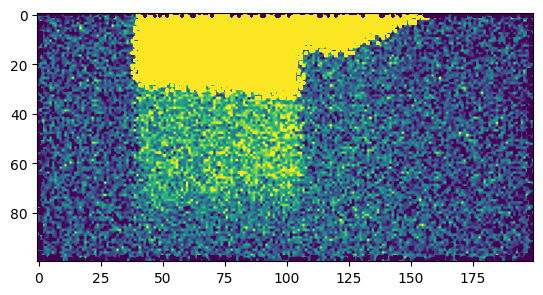

In [55]:
X = jsampler(key, Y[:,:], sig);
print(X.shape)

plt.imshow(X[:,:,2], vmin=0, vmax=4)

In [ ]:
@jit
def jsimulater(key, args):
    key, tr = sensor_model.simulate(key, args)
    return key, tr.strip()

key, tr = jsimulater(key, (Y, sig))

In [ ]:
%timeit -n 1 -r 1  jsimulater(key, (Y, sig));
tr.strip()

In [ ]:
def check_image(X, zmax):
    D = jnp.linalg.norm(X[:,:,:3], axis=2)
    zmax_ = D/X[:,:,2]*zmax
    X_ = jnp.where( D[:,:,None] <= zmax_[:,:,None], X, zmax_[:,:,None]*X/D[:,:,None])
    return D <= zmax_, X_

In [ ]:
#|export
import functools
from jax.experimental import checkify

def constrained_lh_mix(x, ys, zmax, sig, outlier):
    # assert , 
    # checkify.check(x[2] > 0.0, "z-coords need to be > 0, but you try to evaluate x = {x} ", x=x)
    

    d, ds, ws = get_1d_mixture_components(x, ys, sig)
    
    # Adjusted zmax: the range at which x intersects the far plane
    # Depends on the behaviour we want...
    zmax_ = d/x[2]*zmax
    
    # TODO: should we clip actually??
    d = jnp.clip(d, 0.0, zmax_)

    logps = truncnorm_logpdf(d, (0.0 - ds)/sig, (zmax_ - ds)/sig, loc=ds, scale=sig)
    logp  = logsumexp(logps + ws)

    logp  = jnp.logaddexp(logp + jnp.log(1.0 - outlier), jnp.log(outlier) - jnp.log(zmax_))
    
    return jnp.where(x[2] <= 0.0, -jnp.inf, logp)

In [ ]:
zmax = 100.0
sig  = 10.
outlier = 0.5

x  = jnp.array([0.,0, 0.8*zmax])
ys = jnp.array([ 
    [-20, 0, 50],
    [-10, 0, 60],
    [10, 0, 90],
    [20, 0, 70],
    [5, 0, 20],
])


d, ds, ws = get_1d_mixture_components(x, ys, sig)

logp = constrained_lh_mix(x, ys, zmax, sig, outlier)
print(logp)

xs = jnp.linspace(-0.1, 1.1, 1_000)[:,None] * jnp.array([0.0,0.0,zmax])[None,]
print(xs[0], xs[-1])

logps = jax.vmap(constrained_lh_mix, (0,None,None,None,None))(xs, ys, zmax, sig, outlier)

print(np.min(logps), np.max(logps))

# ------------------------------
fig, axs = plt.subplots(2,1, figsize=(10,4), sharex=True)

axs[0].set_xlim(-0.1*zmax,1.1*zmax)
axs[0].scatter(ys[:,2], ys[:,0], c="orange")
axs[0].scatter(ds, jnp.zeros(len(ds)),  s=jnp.exp(ws)*300, c="magenta")
axs[0].scatter(d, x[0],marker="x", c="blue");
axs[0].hlines(0, -0.1*zmax,1.1*zmax, color="magenta", zorder=-1, linewidth=0.2)

axs[1].plot(xs[:,2], jnp.exp(logps), c="magenta")
axs[1].scatter(x[2], 0.0, marker="x", c="b")
axs[1].vlines(zmax, 0, jnp.max(jnp.exp(logps)), color="b", linestyle="--")
axs[1].vlines( 0.0, 0, jnp.max(jnp.exp(logps)), color="b", linestyle="--")

In [ ]:
#|export
def constrained_lh_mix_ij(i,j, X, Y_padded, zmax, sig, outlier, w):
    x  = X[i, j, :3]
    ys = dslice(Y_padded, i,j, w)

    return constrained_lh_mix(x, ys, zmax=zmax, sig=sig, outlier=outlier)



def constrained_lh(X, Y, zmax, sig, outlier, w:int):
    """"Likelihood of observation X conditioned on Y."""
    Y_   = jax.lax.pad(Y,  -100., ((w,w,0),(w,w,0),(0,0,0)) )
    
    J, I = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))
    I = I.ravel()
    J = J.ravel()

    f_ij  = lambda i,j: constrained_lh_mix_ij(i, j, X[:,:,:3], Y_[:,:,:3], zmax=zmax, sig=sig, outlier=outlier, w=w) 
    logps = jax.vmap(f_ij)(I, J)

    return logps.sum()


constrained_lh_jit = jit(constrained_lh,static_argnames=("w",))

In [ ]:
def baseline_ij(
    i, j,
    observed_xyz: jnp.ndarray,
    rendered_xyz_padded: jnp.ndarray,
    variance,
    filter_size: int,
):
    distances = (
        observed_xyz[i, j, :3] - 
        jax.lax.dynamic_slice(rendered_xyz_padded, (i, j, 0), (2*filter_size + 1, 2*filter_size + 1, 3))
    )
    probability = jax.scipy.special.logsumexp(
        jax.scipy.stats.norm.logpdf(
            distances,
            loc=0.0,
            scale=jnp.sqrt(variance)
        ).sum(-1) - jnp.log((2*filter_size + 1)**2)
    )
    return probability

In [ ]:
zmax    = 20.1
sig     = .5
var     = sig**2
w       = 3
outlier = 0.0

X = imgs[2,:,:,:3]
Y = imgs[2,:,:,:3]
Y_ = pad(Y, w)


J, I = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))
I = I.ravel()
J = J.ravel()


P = jax.vmap(constrained_lh_mix_ij, (0,0,None,None, None,None,None,None))(I, J, X, Y_, zmax, sig, outlier, w)
Q = jax.vmap(baseline_ij, (0,0,None,None, None,None))(I, J, X, Y_, var, w)
P = P.reshape(X.shape[:2])
Q = Q.reshape(X.shape[:2])


fig, axs = plt.subplots(1,2, figsize=(8,2))
axs[0].set_title("B3D")
axs[0].imshow(P)
axs[1].set_title("3DP3")
axs[1].imshow(Q)

plt.figure(figsize=(4,1))
plt.hist(jnp.exp(P-Q).ravel(), bins=100);

In [ ]:
zmax    = 20.
sig     = .5
var     = sig**2
outlier = 0.2
outlier_vol = 100. 
w       = 4

args = (zmax, sig, outlier, w)


X = imgs[2,:,:,:3]
Y = imgs[5,:,:,:3]


print(X.shape[0]*X.shape[1]*truncnorm_logpdf(zmax/2, (0.0 - zmax/2)/sig, (zmax - zmax/2)/sig, loc=zmax/2, scale=sig))

logp = constrained_lh_jit(X, Y, *args)
print(logp)
print(logp - jnp.log(X.shape[0]*X.shape[1]))

plt.figure(figsize=(8,2))
plt.imshow(jnp.concatenate([X[:,:,2],Y[:,:,2]], axis=1), vmin=0., vmax=5)

In [ ]:
#|export
def img_mean_and_var(X, zmax, sig, w):

    # Pixel-wise mean and var
    def mean_and_var_ij(i,j):        

        x  = X[i, j, :3]
        ys = dslice(pad(X,w), i,j, w)
        # ys = adjusted_dslice(X,i,j,w)

        d, ds, ws = get_1d_mixture_components(x, ys, sig)

        mu  = jnp.sum(jnp.exp(ws)*ds)
        std = mix_std(jnp.exp(ws), ds, sig)

        return mu, std**2

    I, J = jnp.mgrid[:X.shape[0], :X.shape[1]]
    I = I.ravel()
    J = J.ravel()

    mu, var = vmap(mean_and_var_ij)(I, J)
    return mu.reshape(*X.shape[:2]), var.reshape(*X.shape[:2])

In [ ]:
zmax = 20.0
sig  = .2
out  = 0.1
w    = 11

mu, var  = img_mean_and_var(X, zmax, sig, w)
std = jnp.sqrt(var)
print(mu.shape)
print(mu[0,0])

# -------------------------
vmin = 0.
vmax = 5.
fig, axs = plt.subplots(1,3, figsize=(10,3))
fig.suptitle(f"w={w}, sig={sig}")
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

axs[0].set_title("original")
axs[0].imshow(X[:,:,2], vmin=vmin, vmax=vmax, cmap="binary_r")
axs[1].set_title("Mean")
axs[1].imshow(mu, vmin=vmin, vmax=vmax, cmap="binary_r")
axs[2].set_title("Std. Dev.")
axs[2].imshow(std, vmin=vmin, vmax=vmax, cmap="binary_r");
fig.tight_layout(rect=[0, 0.03, 1., 1.])

In [ ]:
X = imgs[10,:,:,:]
Y = imgs[2,:,:,:]
zmax=20.
sig=0.2
outlier=0.1
w= 5
args = (zmax, sig, outlier, w)

constrained_lh(X, Y, *args)
%timeit -n 1 -r 1 constrained_lh(X, Y, *args);

In [ ]:
pad_jit(X, w);

In [ ]:
#|export
from genjax.generative_functions.distributions import ExactDensity

class B3DImageLikelihood(ExactDensity):
    def sample(self, key, Y, zmax, sig, outlier, w:int):
        # TODO: write this method
        return Y

    def logpdf(self, X, Y, zmax, sig, outlier, w:int):
        return constrained_lh_jit(X, Y, zmax, sig, outlier, w)

b3d_image_likelihood = B3DImageLikelihood()


## Testing

In [ ]:
zmax = 100.0
sig = 0.1
out = 0.1
w = 21

constrained_lh(X, Y, zmax, sig, out, w)

In [ ]:
zmax = 100.0
sig = 10.0

x  = jnp.array([0.,67.,0.])
ys = jnp.array([ 
    [-20, 50, 0],
    [-10, 60, 0],
    [10, 90, 0],
    [20, 70, 0],
    [5, 20, 0],
])


z = jnp.linalg.norm(x)

zs_ = ys @ x / z
ws_ = jnp.linalg.norm(zs_[...,None] * x/z - ys, axis=-1)
ws_ = normal_logpdf(ws_, loc=0.0, scale=sig)
ws_ = ws_ - logsumexp(ws_)
logps = truncnorm_logpdf(z, (0.0 - zs_)/sig, (zmax - zs_)/sig, loc=zs_, scale=sig)
logp  = logsumexp(logps + ws_)


vs = zs_[...,None] * x/z



# ------------------------------
plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.scatter(ys[:,0], ys[:,1], c="orange")
plt.scatter(vs[:,0], zs_,  s=jnp.exp(ws_)*2_00, c="magenta")
plt.scatter(x[0], z, marker="x", c="blue");

In [ ]:
xs = jnp.linspace(0.0, zmax, 100)[:,None] * x/z


ps = vmap(lambda x: constrained_lh_mix(x, ys, zmax=100.0, sig=10.))(xs)

plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.scatter(xs[:,0], xs[:,1], c = ps)
plt.scatter(ys[:,0], ys[:,1])

In [ ]:
plt.figure(figsize=(4,1))
plt.plot(jnp.exp(ps), marker=".")

In [ ]:
imgs = []
for t in range(10):
    im = np.load(f"./data/test_imgs/img_{t}.npy")
    imgs.append(jnp.array(im))

imgs = jnp.array(imgs)
imgs.shape


X = imgs[3]
Y = imgs[2]


plt.imshow(jnp.concatenate([X[:,:,2],Y[:,:,2]]), vmin=0., vmax=5)

In [ ]:


# J, I = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))
# I.shape, J.shape
# jj, ii = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))
# indices = jnp.stack([ii,jj],axis=-1)
# indices.shape